<a href="https://colab.research.google.com/github/Hesham-Elwakeel/Deep-Learnign-Projeacts/blob/main/Real%20Time%20Tomato%20Ripeness%20Detection/Real_time_Tomato_Ripeness_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
import cv2
import random
import shutil
from datetime import datetime

# TensorFlow & Keras
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

# Sklearn
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# Google Colab
from google.colab import drive, files

np.random.seed(42)
tf.random.set_seed(42)

In [6]:
# path of the project
PROJECT_PATH = '/content/drive/MyDrive/Projects/tomato_ripeness_detection'

# data path
DATA_PATH = f'{PROJECT_PATH}/data/Tomato Maturity Detection and Quality Grading Dataset/Tomato Maturity Detection Dataset/Tomato Maturity Detection Dataset/Augment Dataset'

# mode save path
MODEL_SAVE_PATH = f'{PROJECT_PATH}/models'
RESULTS_PATH = f'{PROJECT_PATH}/results'


os.makedirs(MODEL_SAVE_PATH, exist_ok=True)
os.makedirs(RESULTS_PATH, exist_ok=True)

# Category paths

IMMATURE_PATH = os.path.join(DATA_PATH, 'Immature')
MATURE_PATH = os.path.join(DATA_PATH, 'Mature')

#ensuring the data is available
print(f"Immature: {len(os.listdir(IMMATURE_PATH))}")
print(f"Mature: {len(os.listdir(MATURE_PATH))}")
print(f"\nThe routes have been successfully identified")

Immature: 2000
Mature: 2000

The routes have been successfully identified


info about Dataset

Immature: 2000
Mature: 2000
total of images : 4000
the balance of images: 50.0% : 50.0%


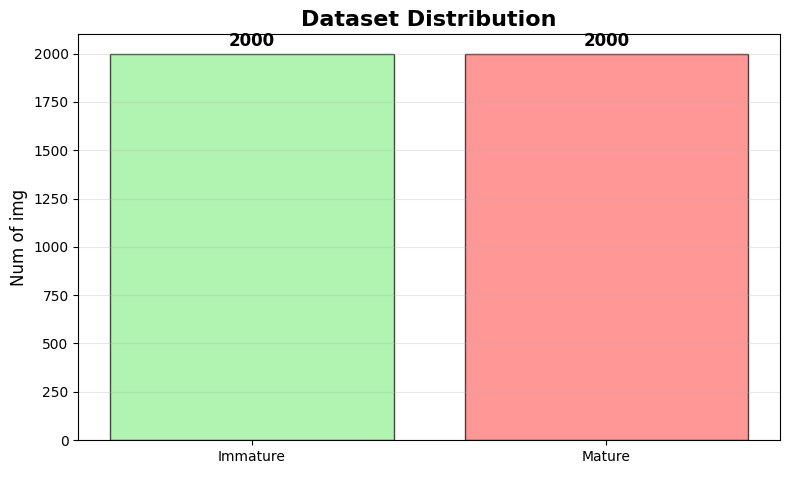

The distribution chart has been saved in: /content/drive/MyDrive/Projects/tomato_ripeness_detection/results/data_distribution.png


In [8]:
immature_count = len(os.listdir(IMMATURE_PATH))
mature_count = len(os.listdir(MATURE_PATH))
total_images = immature_count + mature_count



print("info about Dataset")

print(f"\nImmature: {immature_count}")
print(f"Mature: {mature_count}")
print(f"total of images : {total_images}")
print(f"the balance of images: {immature_count/total_images*100:.1f}% : {mature_count/total_images*100:.1f}%")


#Plot the data distribution
plt.figure(figsize=(8, 5))
categories = ['Immature\n', 'Mature']
counts = [immature_count, mature_count]
colors = ['#90EE90', '#FF6B6B']

bars = plt.bar(categories, counts, color=colors, alpha=0.7, edgecolor='black')
plt.title('Dataset Distribution', fontsize=16, weight='bold')
plt.ylabel('Num of img', fontsize=12)
plt.grid(axis='y', alpha=0.3)

# nums above the columns
for bar, count in zip(bars, counts):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 20,
             str(count), ha='center', va='bottom', fontsize=12, weight='bold')

plt.tight_layout()
plt.savefig(f'{RESULTS_PATH}/data_distribution.png', dpi=300, bbox_inches='tight')
plt.show()

print("The distribution chart has been saved in:", f'{RESULTS_PATH}/data_distribution.png')

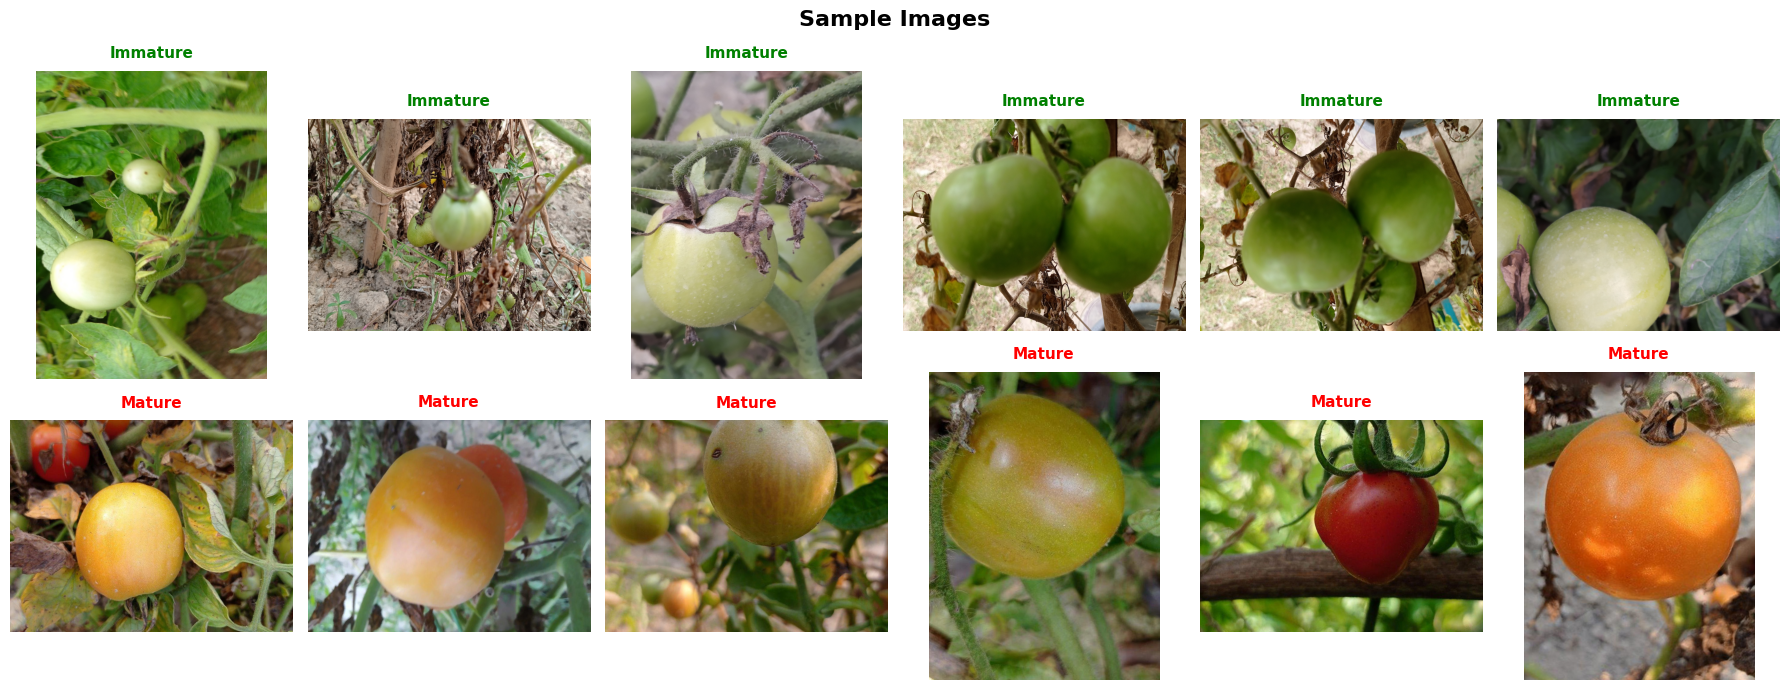

 /content/drive/MyDrive/Projects/tomato_ripeness_detection/results/sample_images.png


In [9]:
def display_sample_images(immature_path, mature_path, num_samples=6):

    fig, axes = plt.subplots(2, num_samples, figsize=(18, 7))
    fig.suptitle('Sample Images', fontsize=16, weight='bold', y=0.98)

    # Immature
    immature_images = os.listdir(immature_path)
    immature_samples = random.sample(immature_images, num_samples)

    for i, img_name in enumerate(immature_samples):
        img_path = os.path.join(immature_path, img_name)
        img = Image.open(img_path)
        axes[0, i].imshow(img)
        axes[0, i].axis('off')
        axes[0, i].set_title('Immature', fontsize=11, weight='bold',
                            color='green', pad=10)

    # Mature
    mature_images = os.listdir(mature_path)
    mature_samples = random.sample(mature_images, num_samples)

    for i, img_name in enumerate(mature_samples):
        img_path = os.path.join(mature_path, img_name)
        img = Image.open(img_path)
        axes[1, i].imshow(img)
        axes[1, i].axis('off')
        axes[1, i].set_title('Mature', fontsize=11, weight='bold',
                            color='red', pad=10)

    plt.tight_layout()
    plt.savefig(f'{RESULTS_PATH}/sample_images.png', dpi=300, bbox_inches='tight')
    plt.show()

    print("", f'{RESULTS_PATH}/sample_images.png')

display_sample_images(IMMATURE_PATH, MATURE_PATH, num_samples=6)

# Cell 7(Model Configuration)


In [20]:
IMG_SIZE = (224, 224)  # img size
BATCH_SIZE = 32        # num of images in each batch
epochs = 25            # num of traning

#model configuration
LR = 0.0001  # learning rate
validation_split = 0.15  # validation
test_split = 0.15        #test

#class names
class_names = ['Immature', 'Mature']
NUM_CLASSES = len(CLASS_NAMES)

print("model congiguration")
print(f"\nimg size {IMG_SIZE}")
print(f"Batch Size: {BATCH_SIZE}")
print(f"Epochs: {epochs}")
print(f"Learning Rate: {LR}")
print(f"Validation Split: {validation_split*100}%")
print(f"Test Split: {test_split*100}%")
print(f"Classes: {class_names}")

model congiguration

img size (224, 224)
Batch Size: 32
Epochs: 25
Learning Rate: 0.0001
Validation Split: 15.0%
Test Split: 15.0%
Classes: ['Immature', 'Mature']


# Split Data into Train/Val/Test

In [31]:
SPLIT_DATA_PATH = '/content/tomato_data_split'
TRAIN_DIR = os.path.join(SPLIT_DATA_PATH, 'train')
VAL_DIR = os.path.join(SPLIT_DATA_PATH, 'validation')
TEST_DIR = os.path.join(SPLIT_DATA_PATH, 'test')

#delete old folders if they exist
if os.path.exists(SPLIT_DATA_PATH):
    shutil.rmtree(SPLIT_DATA_PATH)

# creating new folders
for dir_path in [TRAIN_DIR, VAL_DIR, TEST_DIR]:
    for class_name in CLASS_NAMES:
        os.makedirs(os.path.join(dir_path, class_name), exist_ok=True)

print("Partition folders have been created")

def split_data(source_path, class_name, train_dir, val_dir, test_dir, val_split=0.15, test_split=0.15):

#get all images (only files in image formats)
    all_files = os.listdir(source_path)
    all_images = [f for f in all_files if f.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.gif'))]
    random.shuffle(all_images)

    # Count the number of images per set
    total_images = len(all_images)
    test_count = int(total_images * test_split)
    val_count = int(total_images * val_split)
    train_count = total_images - test_count - val_count

    # split images
    test_images = all_images[:test_count]
    val_images = all_images[test_count:test_count + val_count]
    train_images = all_images[test_count + val_count:]


    copied_train = 0
    copied_val = 0
    copied_test = 0

    for img_name in train_images:
        try:
            src = os.path.join(source_path, img_name)
            if os.path.exists(src):  # Checking the file
                dst = os.path.join(train_dir, class_name, img_name)
                shutil.copy2(src, dst)
                copied_train += 1
        except Exception as e:
            print(f"{img_name}: {str(e)}")

    for img_name in val_images:
        try:
            src = os.path.join(source_path, img_name)
            if os.path.exists(src):
                dst = os.path.join(val_dir, class_name, img_name)
                shutil.copy2(src, dst)
                copied_val += 1
        except Exception as e:
            print(f"{img_name}: {str(e)}")

    for img_name in test_images:
        try:
            src = os.path.join(source_path, img_name)
            if os.path.exists(src):
                dst = os.path.join(test_dir, class_name, img_name)
                shutil.copy2(src, dst)
                copied_test += 1
        except Exception as e:
            print(f"{img_name}: {str(e)}")

    return copied_train, copied_val, copied_test

#data partitioning for each category
immature_splits = split_data(IMMATURE_PATH, 'Immature', TRAIN_DIR, VAL_DIR, TEST_DIR, VALIDATION_SPLIT, TEST_SPLIT)
mature_splits = split_data(MATURE_PATH, 'Mature', TRAIN_DIR, VAL_DIR, TEST_DIR, VALIDATION_SPLIT, TEST_SPLIT)

print("data partitioning results")
print(f"{'Class':<15} {'Train':<10} {'Validation':<12} {'Test':<10} {'Total':<10}")
print(f"{'Immature':<15} {immature_splits[0]:<10} {immature_splits[1]:<12} {immature_splits[2]:<10} {sum(immature_splits):<10}")
print(f"{'Mature':<15} {mature_splits[0]:<10} {mature_splits[1]:<12} {mature_splits[2]:<10} {sum(mature_splits):<10}")
print(f"{'Total':<15} {immature_splits[0]+mature_splits[0]:<10} {immature_splits[1]+mature_splits[1]:<12} {immature_splits[2]+mature_splits[2]:<10} {sum(immature_splits)+sum(mature_splits):<10}")

print(f"Train Immature: {len(os.listdir(os.path.join(TRAIN_DIR, 'Immature')))}")
print(f"Train Mature: {len(os.listdir(os.path.join(TRAIN_DIR, 'Mature')))}")
print(f"Val Immature: {len(os.listdir(os.path.join(VAL_DIR, 'Immature')))}")
print(f"Val Mature: {len(os.listdir(os.path.join(VAL_DIR, 'Mature')))}")
print(f"Test Immature: {len(os.listdir(os.path.join(TEST_DIR, 'Immature')))}")
print(f"Test Mature: {len(os.listdir(os.path.join(TEST_DIR, 'Mature')))}")

print("\nThe data was successfully split")

Partition folders have been created
data partitioning results
Class           Train      Validation   Test       Total     
Immature        1400       300          300        2000      
Mature          1400       300          300        2000      
Total           2800       600          600        4000      
Train Immature: 1400
Train Mature: 1400
Val Immature: 300
Val Mature: 300
Test Immature: 300
Test Mature: 300

The data was successfully split


# cell9 Data Generators (Data Augmentation)

In [32]:
"""
We use ImageDataGenerator to load and prepare data with Data Augmentation"""

# Data Augmentation for training data only
train_datagen = ImageDataGenerator(
    rescale=1./255,              # normalizing values from 0:255 to 0:1
    rotation_range=20,           # random rotation
    width_shift_range=0.2,       # horizontal displacement
    height_shift_range=0.2,      # Vertical displacement
    horizontal_flip=True,        # horizontal flip
    zoom_range=0.2,              # zoom in / zoom out
    shear_range=0.2,             # crop
    fill_mode='nearest'          # fill the blanks
)


# for validation and testing, we only use rescaling (without augmentation).
val_test_datagen = ImageDataGenerator(rescale=1./255)

# Create generators
train_generator = train_datagen.flow_from_directory(
    TRAIN_DIR,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary',  # binary because we only have two categories
    shuffle=True
)

validation_generator = val_test_datagen.flow_from_directory(
    VAL_DIR,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary',
    shuffle=False
)

test_generator = val_test_datagen.flow_from_directory(
    TEST_DIR,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary',
    shuffle=False
)

print(f"Training samples: {train_generator.samples}")
print(f"Validation samples: {validation_generator.samples}")
print(f"Test samples: {test_generator.samples}")

Found 2800 images belonging to 2 classes.
Found 600 images belonging to 2 classes.
Found 600 images belonging to 2 classes.
Training samples: 2800
Validation samples: 600
Test samples: 600


# call 10 Transfer Learning (Build Model)

In [33]:
"""
We build the model using Transfer Learning with MobileNetV2"""

def create_model(img_size=IMG_SIZE, num_classes=1):

    # use MobileNetV2 pre-trained on ImageNet
    base_model = MobileNetV2(
        input_shape=(*img_size, 3),
        include_top=False,  #delete the top layers
        weights='imagenet'   # use imagnet weights
    )

    ## freeze the base model layers (we don't want to train them initially)
    base_model.trainable = False

    # Build the complete model
    inputs = keras.Input(shape=(*img_size, 3))

    # Data augmentation layer (optional - already done in generator)
    x = base_model(inputs, training=False)

    # إضافة طبقات مخصصة
    x = GlobalAveragePooling2D()(x)  #convert feature to vector
    x = Dropout(0.3)(x)              # dropout to prevent overfitting
    x = Dense(128, activation='relu')(x)  #Dense layer
    x = Dropout(0.2)(x)

    # output layer (sigmoid for binary classification)
    outputs = Dense(num_classes, activation='sigmoid')(x)

   #create the final model
    model = Model(inputs, outputs)

    return model, base_model

# create the final model
model, base_model = create_model()

#model summary
print("model Architecture")
model.summary()

print(f"\nTotal num of layers:{len(model.layers)}")
print(f"num of frozen layers in base model:{len(base_model.layers)}")

model Architecture


Model: "functional_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_13 (InputLayer)     │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_6      │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_12 (Dropout)            │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 128)            │       163,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_13 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,422,081 (9.24 MB)

 Trainable params: 164,097 (641.00 KB)

 Non-trainable params: 2,257,984 (8.61 MB)


Total num of layers:7
num of frozen layers in base model:154


# call 11 compile model


We assemble the model by defining the optimizer, loss function, and metrics.

In [34]:
model.compile(
    optimizer=Adam(learning_rate=LR),
    loss='binary_crossentropy',
    metrics=['accuracy',
             tf.keras.metrics.Precision(name='precision'),
             tf.keras.metrics.Recall(name='recall')]
)

print(f"Optimizer: Adam (LR={LR})")
print(f"Loss Function: Binary Crossentropy")
print(f"Metrics: Accuracy, Precision, Recall")


Optimizer: Adam (LR=0.0001)
Loss Function: Binary Crossentropy
Metrics: Accuracy, Precision, Recall


# Cell 12: Callbacks (to control the training process)

In [35]:
model_filename = f'tomato_ripeness_model_{datetime.now().strftime("%Y%m%d_%H%M%S")}.h5'
model_filepath = os.path.join(MODEL_SAVE_PATH, model_filename)

callbacks = [
    # early Stopping: Stop training if there is no improvement
    EarlyStopping(
        monitor='val_loss',
        patience=5,
        restore_best_weights=True,
        verbose=1
    ),

    # # Model Checkpoint: Save the best model
    ModelCheckpoint(
        filepath=model_filepath,
        monitor='val_accuracy',
        save_best_only=True,
        verbose=1
    ),

    # Reduce Learning Rate: reduce the learning rate if there is no improvement
    ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=3,
        min_lr=1e-7,
        verbose=1
    )
]

print("Callbacks:")
print("Early Stopping (patience=5)")
print("Model Checkpoint (save best model)")
print("Reduce LR on Plateau (factor=0.5, patience=3)")

Callbacks:
Early Stopping (patience=5)
Model Checkpoint (save best model)
Reduce LR on Plateau (factor=0.5, patience=3)



# Cell 13: Model Training - Phase 1

**Phase 1: Training only the custom layers (frozen base model)**

In [36]:
print("Base Model frozen Custom Layer training Only")

history_phase1 = model.fit(
    train_generator,
    epochs=epochs,
    validation_data=validation_generator,
    callbacks=callbacks,
    verbose=1
)

Base Model frozen Custom Layer training Only


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/25
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.6743 - loss: 0.5989 - precision: 0.6741 - recall: 0.6614
Epoch 1: val_accuracy improved from -inf to 0.97167, saving model to /content/drive/MyDrive/Projects/tomato_ripeness_detection/models/tomato_ripeness_model_20251031_053337.h5


88/88 ━━━━━━━━━━━━━━━━━━━━ 292s 3s/step - accuracy: 0.6758 - loss: 0.5968 - precision: 0.6757 - recall: 0.6630 - val_accuracy: 0.9717 - val_loss: 0.1337 - val_precision: 0.9639 - val_recall: 0.9800 - learning_rate: 1.0000e-04
Epoch 2/25
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.9496 - loss: 0.1643 - precision: 0.9537 - recall: 0.9382
Epoch 2: val_accuracy improved from 0.97167 to 0.97833, saving model to /content/drive/MyDrive/Projects/tomato_ripeness_detection/models/tomato_ripeness_model_20251031_053337.h5


88/88 ━━━━━━━━━━━━━━━━━━━━ 310s 3s/step - accuracy: 0.9497 - loss: 0.1640 - precision: 0.9538 - recall: 0.9384 - val_accuracy: 0.9783 - val_loss: 0.0859 - val_precision: 0.9736 - val_recall: 0.9833 - learning_rate: 1.0000e-04
Epoch 3/25
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9673 - loss: 0.0997 - precision: 0.9786 - recall: 0.9554
Epoch 3: val_accuracy improved from 0.97833 to 0.98167, saving model to /content/drive/MyDrive/Projects/tomato_ripeness_detection/models/tomato_ripeness_model_20251031_053337.h5


88/88 ━━━━━━━━━━━━━━━━━━━━ 260s 3s/step - accuracy: 0.9673 - loss: 0.0997 - precision: 0.9786 - recall: 0.9555 - val_accuracy: 0.9817 - val_loss: 0.0744 - val_precision: 0.9738 - val_recall: 0.9900 - learning_rate: 1.0000e-04
Epoch 4/25
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.9778 - loss: 0.0789 - precision: 0.9789 - recall: 0.9765
Epoch 4: val_accuracy improved from 0.98167 to 0.98500, saving model to /content/drive/MyDrive/Projects/tomato_ripeness_detection/models/tomato_ripeness_model_20251031_053337.h5


88/88 ━━━━━━━━━━━━━━━━━━━━ 275s 3s/step - accuracy: 0.9777 - loss: 0.0790 - precision: 0.9788 - recall: 0.9764 - val_accuracy: 0.9850 - val_loss: 0.0608 - val_precision: 0.9834 - val_recall: 0.9867 - learning_rate: 1.0000e-04
Epoch 5/25
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.9796 - loss: 0.0713 - precision: 0.9877 - recall: 0.9701
Epoch 5: val_accuracy did not improve from 0.98500
88/88 ━━━━━━━━━━━━━━━━━━━━ 309s 4s/step - accuracy: 0.9795 - loss: 0.0713 - precision: 0.9877 - recall: 0.9701 - val_accuracy: 0.9850 - val_loss: 0.0593 - val_precision: 0.9802 - val_recall: 0.9900 - learning_rate: 1.0000e-04
Epoch 6/25
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.9792 - loss: 0.0676 - precision: 0.9771 - recall: 0.9827
Epoch 6: val_accuracy did not improve from 0.98500
88/88 ━━━━━━━━━━━━━━━━━━━━ 267s 3s/step - accuracy: 0.9792 - loss: 0.0675 - precision: 0.9772 - recall: 0.9827 - val_accuracy: 0.9833 - val_loss: 0.0524 - val_precision: 0.9833 - val_recall: 0.9833 - learni

88/88 ━━━━━━━━━━━━━━━━━━━━ 261s 3s/step - accuracy: 0.9850 - loss: 0.0447 - precision: 0.9856 - recall: 0.9840 - val_accuracy: 0.9867 - val_loss: 0.0515 - val_precision: 0.9803 - val_recall: 0.9933 - learning_rate: 1.0000e-04
Epoch 11/25
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.9825 - loss: 0.0451 - precision: 0.9882 - recall: 0.9773
Epoch 11: val_accuracy improved from 0.98667 to 0.98833, saving model to /content/drive/MyDrive/Projects/tomato_ripeness_detection/models/tomato_ripeness_model_20251031_053337.h5


88/88 ━━━━━━━━━━━━━━━━━━━━ 269s 3s/step - accuracy: 0.9825 - loss: 0.0451 - precision: 0.9882 - recall: 0.9773 - val_accuracy: 0.9883 - val_loss: 0.0461 - val_precision: 0.9835 - val_recall: 0.9933 - learning_rate: 1.0000e-04
Epoch 12/25
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9829 - loss: 0.0491 - precision: 0.9858 - recall: 0.9802
Epoch 12: val_accuracy did not improve from 0.98833
88/88 ━━━━━━━━━━━━━━━━━━━━ 257s 3s/step - accuracy: 0.9829 - loss: 0.0492 - precision: 0.9858 - recall: 0.9802 - val_accuracy: 0.9883 - val_loss: 0.0455 - val_precision: 0.9835 - val_recall: 0.9933 - learning_rate: 1.0000e-04
Epoch 13/25
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.9814 - loss: 0.0488 - precision: 0.9855 - recall: 0.9774
Epoch 13: val_accuracy did not improve from 0.98833
88/88 ━━━━━━━━━━━━━━━━━━━━ 275s 3s/step - accuracy: 0.9815 - loss: 0.0487 - precision: 0.9855 - recall: 0.9774 - val_accuracy: 0.9867 - val_loss: 0.0428 - val_precision: 0.9834 - val_recall: 0.9900 - le

## Cell 14: Fine-tuning - Phase 2 (Train Model - Phase 2)

**Phase Two: Fine-tuning - Unfreezing some base model layers**

In [41]:
print("# Defrost the last 30 layers of the base model")
base_model.trainable = True
fine_tune_at = len(base_model.layers) - 30


# Freeze all layers before fine_tune_at
for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False

print(f"unfrozen{len(base_model.layers) - fine_tune_at} layer")
print(f"num of frozen layers: {fine_tune_at}")
print(f"Number of trainable layers{len(base_model.layers) - fine_tune_at}")


# Recompiling at a lower learning rate
model.compile(
    optimizer=Adam(learning_rate=LEARNING_RATE/10),  # learning rate lower for fine-tuning
    loss='binary_crossentropy',
    metrics=['accuracy',
             tf.keras.metrics.Precision(name='precision'),
             tf.keras.metrics.Recall(name='recall')]
)

print(f"nnew Learning Rate: {LEARNING_RATE/10}")

# update file name
model_filename_finetuned = f'tomato_ripeness_model_finetuned_{datetime.now().strftime("%Y%m%d_%H%M%S")}.h5'
model_filepath_finetuned = os.path.join(MODEL_SAVE_PATH, model_filename_finetuned)

# update callbacks
callbacks_phase2 = [
    EarlyStopping(
        monitor='val_loss',
        patience=5,
        restore_best_weights=True,
        verbose=1
    ),
    ModelCheckpoint(
        filepath=model_filepath_finetuned,
        monitor='val_accuracy',
        save_best_only=True,
        verbose=1
    ),
    ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=3,
        min_lr=1e-8,
        verbose=1
    )
]

#fine-tuning
print("-"*5)
history_phase2 = model.fit(
    train_generator,
    epochs=15,
    validation_data=validation_generator,
    callbacks=callbacks_phase2,
    verbose=1
)


# Defrost the last 30 layers of the base model
unfrozen30 layer
num of frozen layers: 124
Number of trainable layers30
nnew Learning Rate: 1e-05
-----
Epoch 1/15
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.8992 - loss: 0.2464 - precision: 0.8368 - recall: 0.9964
Epoch 1: val_accuracy improved from -inf to 0.98667, saving model to /content/drive/MyDrive/Projects/tomato_ripeness_detection/models/tomato_ripeness_model_finetuned_20251031_070421.h5


88/88 ━━━━━━━━━━━━━━━━━━━━ 315s 3s/step - accuracy: 0.8997 - loss: 0.2453 - precision: 0.8376 - recall: 0.9963 - val_accuracy: 0.9867 - val_loss: 0.0470 - val_precision: 0.9803 - val_recall: 0.9933 - learning_rate: 1.0000e-05
Epoch 2/15
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.9828 - loss: 0.0505 - precision: 0.9777 - recall: 0.9878
Epoch 2: val_accuracy improved from 0.98667 to 0.98833, saving model to /content/drive/MyDrive/Projects/tomato_ripeness_detection/models/tomato_ripeness_model_finetuned_20251031_070421.h5


88/88 ━━━━━━━━━━━━━━━━━━━━ 344s 4s/step - accuracy: 0.9828 - loss: 0.0505 - precision: 0.9778 - recall: 0.9877 - val_accuracy: 0.9883 - val_loss: 0.0449 - val_precision: 0.9835 - val_recall: 0.9933 - learning_rate: 1.0000e-05
Epoch 3/15
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.9768 - loss: 0.0588 - precision: 0.9779 - recall: 0.9757
Epoch 3: val_accuracy did not improve from 0.98833
88/88 ━━━━━━━━━━━━━━━━━━━━ 295s 3s/step - accuracy: 0.9768 - loss: 0.0587 - precision: 0.9779 - recall: 0.9758 - val_accuracy: 0.9883 - val_loss: 0.0458 - val_precision: 0.9835 - val_recall: 0.9933 - learning_rate: 1.0000e-05
Epoch 4/15
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.9828 - loss: 0.0487 - precision: 0.9847 - recall: 0.9802
Epoch 4: val_accuracy did not improve from 0.98833
88/88 ━━━━━━━━━━━━━━━━━━━━ 303s 3s/step - accuracy: 0.9828 - loss: 0.0486 - precision: 0.9847 - recall: 0.9801 - val_accuracy: 0.9883 - val_loss: 0.0477 - val_precision: 0.9835 - val_recall: 0.9933 - learni

88/88 ━━━━━━━━━━━━━━━━━━━━ 303s 3s/step - accuracy: 0.9819 - loss: 0.0418 - precision: 0.9829 - recall: 0.9802 - val_accuracy: 0.9900 - val_loss: 0.0429 - val_precision: 0.9868 - val_recall: 0.9933 - learning_rate: 1.0000e-05
Epoch 7/15
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.9824 - loss: 0.0405 - precision: 0.9878 - recall: 0.9773
Epoch 7: val_accuracy did not improve from 0.99000
88/88 ━━━━━━━━━━━━━━━━━━━━ 298s 3s/step - accuracy: 0.9825 - loss: 0.0405 - precision: 0.9879 - recall: 0.9774 - val_accuracy: 0.9900 - val_loss: 0.0434 - val_precision: 0.9868 - val_recall: 0.9933 - learning_rate: 1.0000e-05
Epoch 8/15
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.9913 - loss: 0.0269 - precision: 0.9938 - recall: 0.9892
Epoch 8: val_accuracy did not improve from 0.99000
88/88 ━━━━━━━━━━━━━━━━━━━━ 298s 3s/step - accuracy: 0.9913 - loss: 0.0269 - precision: 0.9938 - recall: 0.9892 - val_accuracy: 0.9900 - val_loss: 0.0392 - val_precision: 0.9868 - val_recall: 0.9933 - learni

88/88 ━━━━━━━━━━━━━━━━━━━━ 305s 3s/step - accuracy: 0.9895 - loss: 0.0282 - precision: 0.9911 - recall: 0.9885 - val_accuracy: 0.9917 - val_loss: 0.0357 - val_precision: 0.9900 - val_recall: 0.9933 - learning_rate: 1.0000e-05
Epoch 11/15
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.9904 - loss: 0.0260 - precision: 0.9906 - recall: 0.9903
Epoch 11: val_accuracy did not improve from 0.99167
88/88 ━━━━━━━━━━━━━━━━━━━━ 299s 3s/step - accuracy: 0.9904 - loss: 0.0260 - precision: 0.9905 - recall: 0.9903 - val_accuracy: 0.9900 - val_loss: 0.0312 - val_precision: 0.9900 - val_recall: 0.9900 - learning_rate: 1.0000e-05
Epoch 12/15
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.9928 - loss: 0.0200 - precision: 0.9934 - recall: 0.9919
Epoch 12: val_accuracy improved from 0.99167 to 0.99333, saving model to /content/drive/MyDrive/Projects/tomato_ripeness_detection/models/tomato_ripeness_model_finetuned_20251031_070421.h5


88/88 ━━━━━━━━━━━━━━━━━━━━ 325s 3s/step - accuracy: 0.9928 - loss: 0.0200 - precision: 0.9934 - recall: 0.9919 - val_accuracy: 0.9933 - val_loss: 0.0309 - val_precision: 0.9901 - val_recall: 0.9967 - learning_rate: 1.0000e-05
Epoch 13/15
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.9951 - loss: 0.0164 - precision: 0.9941 - recall: 0.9961
Epoch 13: val_accuracy did not improve from 0.99333
88/88 ━━━━━━━━━━━━━━━━━━━━ 321s 3s/step - accuracy: 0.9951 - loss: 0.0164 - precision: 0.9941 - recall: 0.9961 - val_accuracy: 0.9933 - val_loss: 0.0303 - val_precision: 0.9901 - val_recall: 0.9967 - learning_rate: 1.0000e-05
Epoch 14/15
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.9899 - loss: 0.0221 - precision: 0.9902 - recall: 0.9889
Epoch 14: val_accuracy did not improve from 0.99333
88/88 ━━━━━━━━━━━━━━━━━━━━ 295s 3s/step - accuracy: 0.9899 - loss: 0.0221 - precision: 0.9902 - recall: 0.9889 - val_accuracy: 0.9933 - val_loss: 0.0258 - val_precision: 0.9901 - val_recall: 0.9967 - le

88/88 ━━━━━━━━━━━━━━━━━━━━ 299s 3s/step - accuracy: 0.9955 - loss: 0.0150 - precision: 0.9968 - recall: 0.9945 - val_accuracy: 0.9950 - val_loss: 0.0245 - val_precision: 0.9934 - val_recall: 0.9967 - learning_rate: 1.0000e-05
Restoring model weights from the end of the best epoch: 15.


# Plot Training History


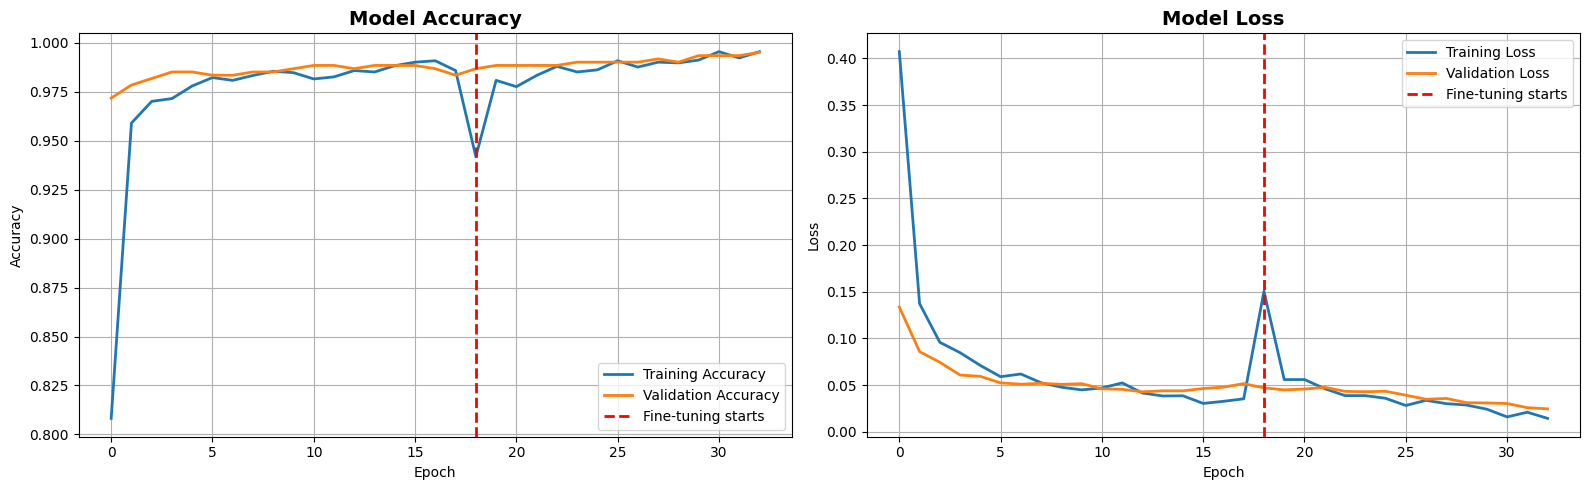

Best Epoch: 33
Best Validation Accuracy: 0.9950
Best Validation Loss: 0.0245


In [44]:

# merging history from both phases
history_combined = {
    'accuracy': history_phase1.history['accuracy'] + history_phase2.history['accuracy'],
    'val_accuracy': history_phase1.history['val_accuracy'] + history_phase2.history['val_accuracy'],
    'loss': history_phase1.history['loss'] + history_phase2.history['loss'],
    'val_loss': history_phase1.history['val_loss'] + history_phase2.history['val_loss']
}

fig, axes = plt.subplots(1, 2, figsize=(16, 5))

# Accuracy
axes[0].plot(history_combined['accuracy'], label='Training Accuracy', linewidth=2)
axes[0].plot(history_combined['val_accuracy'], label='Validation Accuracy', linewidth=2)
axes[0].axvline(x=len(history_phase1.history['loss']), color='red', linestyle='--',
                label='Fine-tuning starts', linewidth=2)
axes[0].set_title('Model Accuracy', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Accuracy')
axes[0].legend()
axes[0].grid(True)

# Loss
axes[1].plot(history_combined['loss'], label='Training Loss', linewidth=2)
axes[1].plot(history_combined['val_loss'], label='Validation Loss', linewidth=2)
axes[1].axvline(x=len(history_phase1.history['loss']), color='red', linestyle='--',
                label='Fine-tuning starts', linewidth=2)
axes[1].set_title('Model Loss', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Loss')
axes[1].legend()
axes[1].grid(True)

plt.tight_layout()
plt.savefig(os.path.join(PROJECT_PATH, 'training_history.png'), dpi=300, bbox_inches='tight')
plt.show()

# Print the best results
best_epoch = np.argmax(history_combined['val_accuracy'])
print(f"Best Epoch: {best_epoch + 1}")
print(f"Best Validation Accuracy: {history_combined['val_accuracy'][best_epoch]:.4f}")
print(f"Best Validation Loss: {history_combined['val_loss'][best_epoch]:.4f}")

# Evaluate model on test set

In [48]:

print("Evaluating model on test set")


print(f"fine-tuned Model (already loaded)")

# Evaluation
test_loss, test_accuracy, test_precision, test_recall = model.evaluate(test_generator, verbose=1)

print(f"\n{'='*70}")
print(f"Test Set:")
print(f"{'='*70}")
print(f"Test Accuracy:  {test_accuracy*100:.2f}%")
print(f"Test Loss:      {test_loss:.4f}")
print(f"Test Precision: {test_precision*100:.2f}%")
print(f"Test Recall:    {test_recall*100:.2f}%")
print(f"{'='*70}")

# Get predictions
test_generator.reset()
y_pred_probs = model.predict(test_generator, verbose=1)

# because we have binary classification (one output with sigmoid)
y_pred = (y_pred_probs > 0.5).astype(int).flatten()
y_true = test_generator.classes

##name of categories
class_names = list(test_generator.class_indices.keys())

print(f"\nClass Mapping: {test_generator.class_indices}")

# Classification Report
print("\n" + "="*70)
print("Classification Report:")
print("="*70)
print(classification_report(y_true, y_pred, target_names=class_names))
print("="*70)

Evaluating model on test set
fine-tuned Model (already loaded)


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


19/19 ━━━━━━━━━━━━━━━━━━━━ 46s 2s/step - accuracy: 0.9988 - loss: 0.0086 - precision: 0.5441 - recall: 0.5500

Test Set:
Test Accuracy:  99.83%
Test Loss:      0.0110
Test Precision: 99.67%
Test Recall:    100.00%
19/19 ━━━━━━━━━━━━━━━━━━━━ 49s 2s/step

Class Mapping: {'Immature': 0, 'Mature': 1}

Classification Report:
              precision    recall  f1-score   support

    Immature       1.00      1.00      1.00       300
      Mature       1.00      1.00      1.00       300

    accuracy                           1.00       600
   macro avg       1.00      1.00      1.00       600
weighted avg       1.00      1.00      1.00       600



 # Cell 16: Plot Confusion Matrix

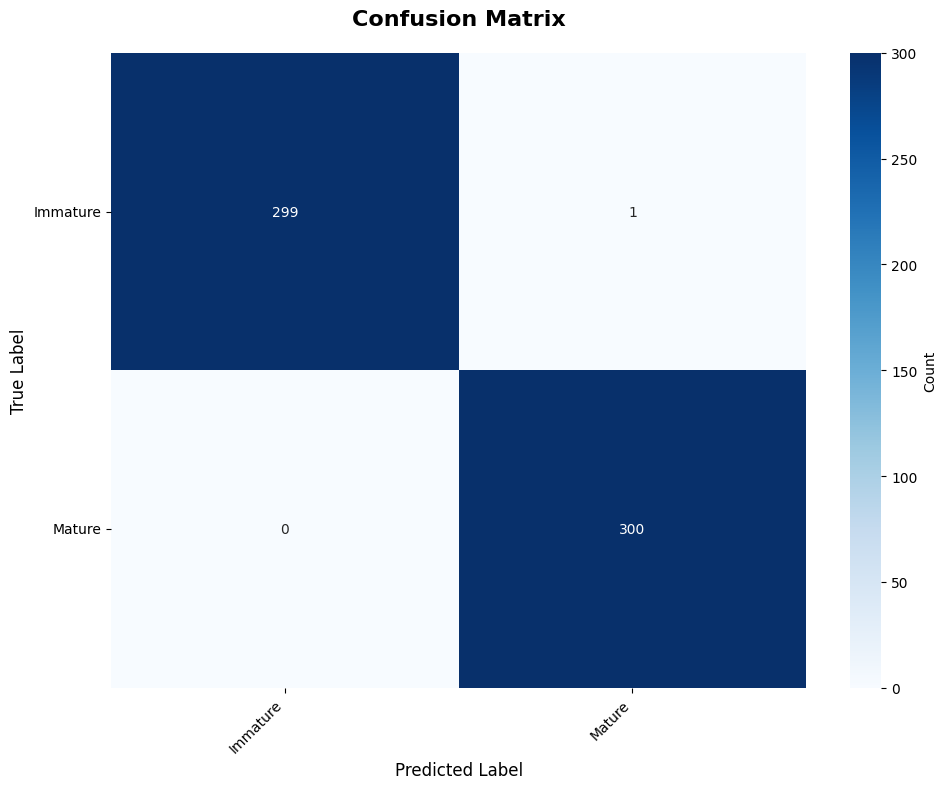

Immature: 99.67%
Mature: 100.00%


In [49]:
#Confusion Matrix
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names,
            cbar_kws={'label': 'Count'})
plt.title('Confusion Matrix', fontsize=16, fontweight='bold', pad=20)
plt.ylabel('True Label', fontsize=12)
plt.xlabel('Predicted Label', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.savefig(os.path.join(PROJECT_PATH, 'confusion_matrix.png'), dpi=300, bbox_inches='tight')
plt.show()

#Calculate the accuracy for each category
class_accuracy = cm.diagonal() / cm.sum(axis=1)
for i, acc in enumerate(class_accuracy):
    print(f"{class_names[i]}: {acc*100:.2f}%")

# Cell 17: Display Prediction Examples

12


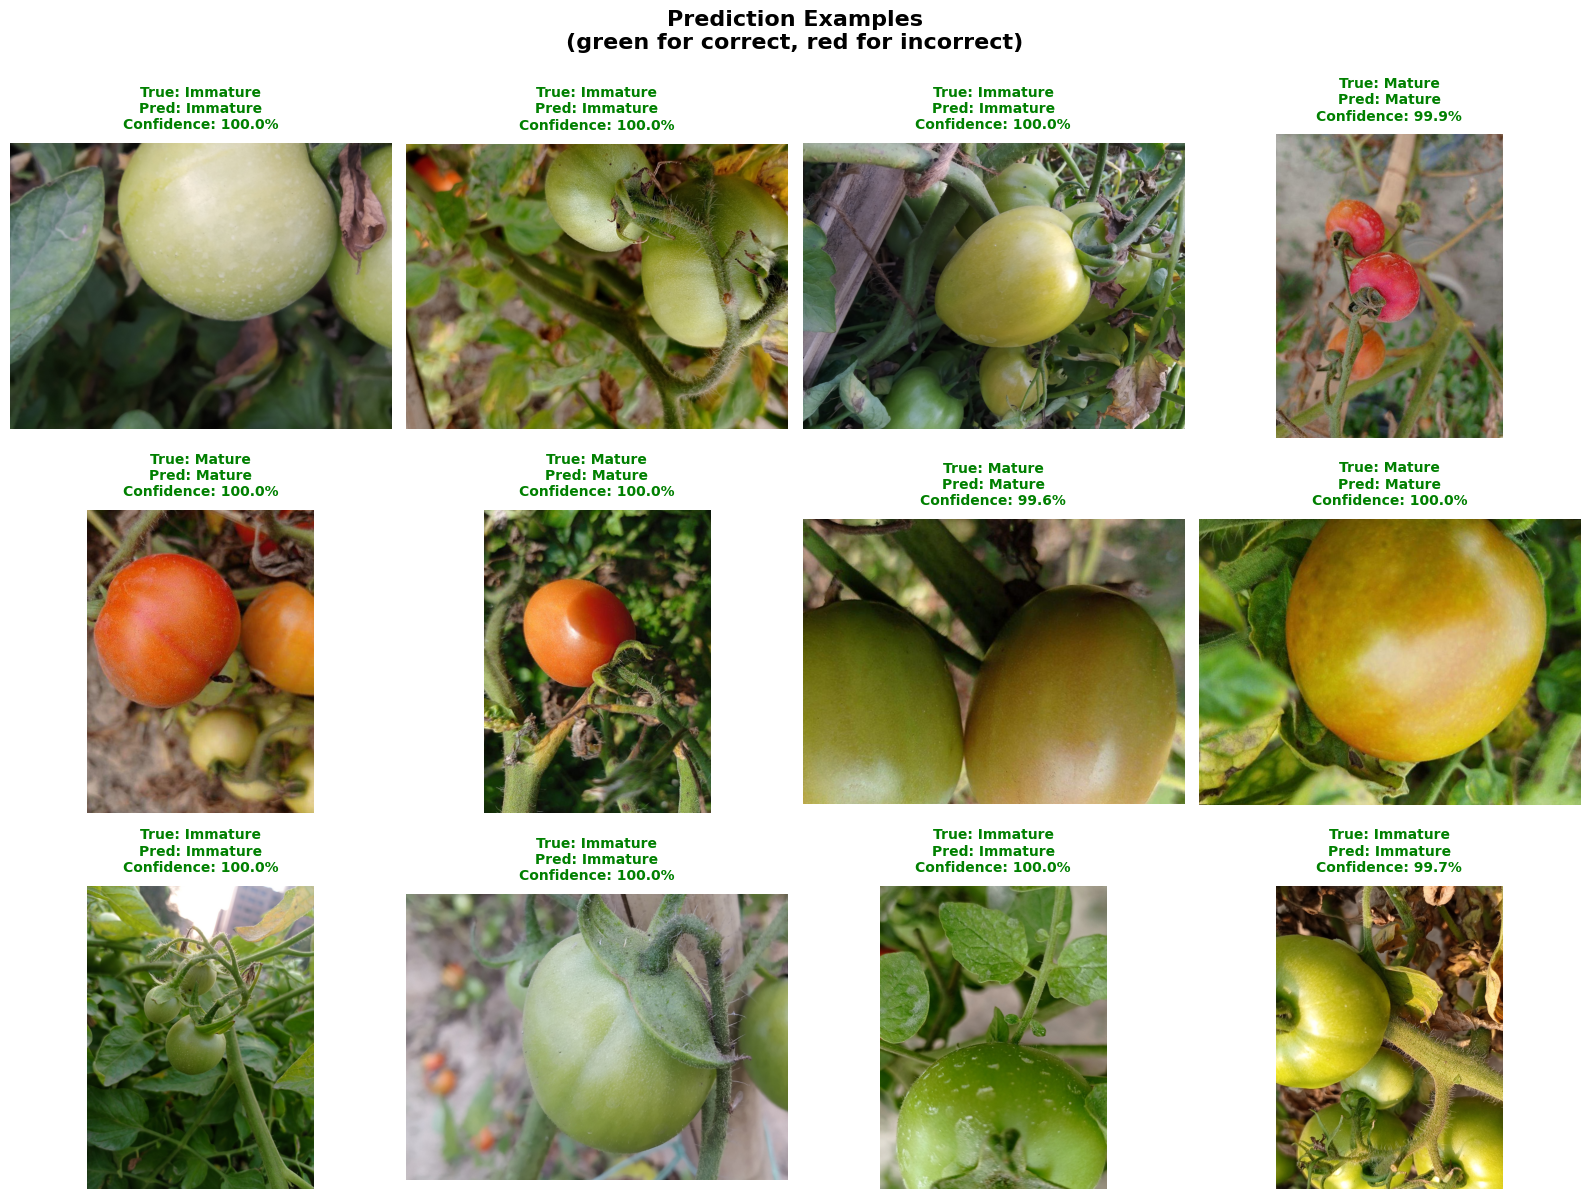

/content/drive/MyDrive/Projects/tomato_ripeness_detection/results/prediction_examples.png

accuracy of the displayed samples: 12/12 (100.0%)


In [52]:

n_samples = 12

# get image paths from test_generator
test_generator.reset()
filenames = test_generator.filenames
true_classes = test_generator.classes
class_indices = test_generator.class_indices
class_names = list(class_indices.keys())


random_indices = np.random.choice(len(filenames), n_samples, replace=False)


fig, axes = plt.subplots(3, 4, figsize=(16, 12))
axes = axes.ravel()

print(f"{n_samples}")

for i, idx in enumerate(random_indices):
    img_relative_path = filenames[idx]
    img_full_path = os.path.join(TEST_DIR, img_relative_path)
    true_label_idx = true_classes[idx]
    true_label = class_names[true_label_idx]

    img = cv2.imread(img_full_path)
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    img_resized = cv2.resize(img_rgb, IMG_SIZE)
    img_array = np.expand_dims(img_resized / 255.0, axis=0)

    pred_prob = model.predict(img_array, verbose=0)[0][0]

   # Convert probability to class
    # 0 = Immature, 1 = Mature (class_indices)
    if pred_prob > 0.5:
        pred_class = 'Mature'
        confidence = pred_prob * 100
    else:
        pred_class = 'Immature'
        confidence = (1 - pred_prob) * 100

    # green for correct, red for incorrect
    is_correct = (pred_class == true_label)
    color = 'green' if is_correct else 'red'
    border_color = 'lightgreen' if is_correct else 'lightcoral'

    axes[i].imshow(img_rgb)
    axes[i].set_title(
        f'True: {true_label}\nPred: {pred_class}\nConfidence: {confidence:.1f}%',
        color=color,
        fontweight='bold',
        fontsize=10,
        pad=10
    )
    axes[i].axis('off')

    # add a colorful frame
    for spine in axes[i].spines.values():
        spine.set_edgecolor(border_color)
        spine.set_linewidth(3)
        spine.set_visible(True)

plt.suptitle('Prediction Examples\n(green for correct, red for incorrect)',
             fontsize=16, fontweight='bold', y=0.995)
plt.tight_layout()
plt.savefig(f'{RESULTS_PATH}/prediction_examples.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"{RESULTS_PATH}/prediction_examples.png")

# Calculating the accuracy of the displayed samples
correct_predictions = sum([
    1 for idx in random_indices
    if (model.predict(
        np.expand_dims(
            cv2.resize(
                cv2.cvtColor(
                    cv2.imread(os.path.join(TEST_DIR, filenames[idx])),
                    cv2.COLOR_BGR2RGB
                ),
                IMG_SIZE
            ) / 255.0,
            axis=0
        ), verbose=0)[0][0] > 0.5) == (true_classes[idx] == 1)
])

print(f"\naccuracy of the displayed samples: {correct_predictions}/{n_samples} ({correct_predictions/n_samples*100:.1f}%)")